# Digit Classifier w/ PyTorch

We are going to do a few things here:

- We want to train a model to identify digits for the individual sudoku cell image that the Recognizer has prepared.
- We want to use this as a Tensorflow Model in the C++

So what are the steps?

1. First train the sudoku digit classifier (aka SudokuNet) model using the MNIST dataset
2. Save the model to the /models folder as a .pb file

## Part I: Setup

### Dependencies

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score

### Get the dataset

In [3]:
# prep training dataset
train_dataset = torchvision.datasets.MNIST(
    './dataset', train=True, 
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ]))

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size_train, 
    shuffle=True
)

# prep test dataset
test_dataset = torchvision.datasets.MNIST(
    './dataset', 
    train=False, 
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ]))

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size_test, 
    shuffle=True
)

### Plot some samples

In [21]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

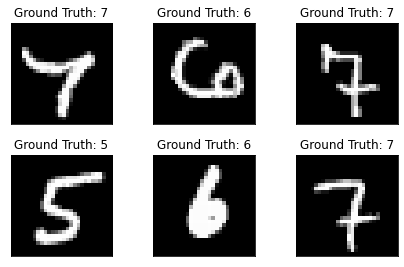

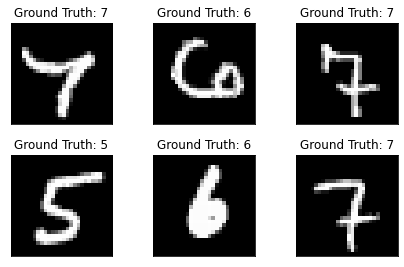

In [4]:

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Part II: Build the model

### Setup

In [165]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

### Create the model

In [166]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
log_interval = 10
lr_step_gamma = 0.7
momentum = 0.5
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [167]:
class SudokuNet(nn.Module):
    def __init__(self):
        super(SudokuNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.dropout1 = nn.Dropout2d(0.5)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv => ReLU => Pool layer
        x = self.conv1(x) 
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # Conv => ReLU => Pool layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # FC => ReLU layer
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = F.log_softmax(x, dim=1)
        return x

### Setup training

## Part III: Train the model

In [168]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [169]:
model = SudokuNet()
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)

In [170]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [171]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [172]:
optimizer = optim.Adadelta(model.parameters(), lr=0.01)

test(model, device, test_loader)
scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()


Test set: Average loss: 2.3043, Accuracy: 909/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.282156
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.291761
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.292744
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.299986
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.295798
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.296472
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.233459
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.285927
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.239610
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.222324
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.254619
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.262919
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.237945
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.205248
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.267284
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.161996
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.177940
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.207276
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.200973
Train Epoch: 1 [1216

Train Epoch: 2 [44160/60000 (74%)]	Loss: 1.364589
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.521056
Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.729441
Train Epoch: 2 [46080/60000 (77%)]	Loss: 1.449301
Train Epoch: 2 [46720/60000 (78%)]	Loss: 1.557527
Train Epoch: 2 [47360/60000 (79%)]	Loss: 1.469815
Train Epoch: 2 [48000/60000 (80%)]	Loss: 1.570067
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.488552
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.452968
Train Epoch: 2 [49920/60000 (83%)]	Loss: 1.528502
Train Epoch: 2 [50560/60000 (84%)]	Loss: 1.638929
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.462472
Train Epoch: 2 [51840/60000 (86%)]	Loss: 1.461021
Train Epoch: 2 [52480/60000 (87%)]	Loss: 1.607907
Train Epoch: 2 [53120/60000 (88%)]	Loss: 1.368488
Train Epoch: 2 [53760/60000 (90%)]	Loss: 1.351241
Train Epoch: 2 [54400/60000 (91%)]	Loss: 1.490487
Train Epoch: 2 [55040/60000 (92%)]	Loss: 1.622581
Train Epoch: 2 [55680/60000 (93%)]	Loss: 1.519265
Train Epoch: 2 [56320/60000 (94%)]	Loss: 1.477096


Train Epoch: 4 [28160/60000 (47%)]	Loss: 1.431876
Train Epoch: 4 [28800/60000 (48%)]	Loss: 1.428551
Train Epoch: 4 [29440/60000 (49%)]	Loss: 1.352257
Train Epoch: 4 [30080/60000 (50%)]	Loss: 1.476019
Train Epoch: 4 [30720/60000 (51%)]	Loss: 1.672989
Train Epoch: 4 [31360/60000 (52%)]	Loss: 1.507587
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.373737
Train Epoch: 4 [32640/60000 (54%)]	Loss: 1.590548
Train Epoch: 4 [33280/60000 (55%)]	Loss: 1.513326
Train Epoch: 4 [33920/60000 (57%)]	Loss: 1.270993
Train Epoch: 4 [34560/60000 (58%)]	Loss: 1.528187
Train Epoch: 4 [35200/60000 (59%)]	Loss: 1.235877
Train Epoch: 4 [35840/60000 (60%)]	Loss: 1.571392
Train Epoch: 4 [36480/60000 (61%)]	Loss: 1.106328
Train Epoch: 4 [37120/60000 (62%)]	Loss: 1.429633
Train Epoch: 4 [37760/60000 (63%)]	Loss: 1.299998
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.376516
Train Epoch: 4 [39040/60000 (65%)]	Loss: 1.389962
Train Epoch: 4 [39680/60000 (66%)]	Loss: 1.490934
Train Epoch: 4 [40320/60000 (67%)]	Loss: 1.304078


Train Epoch: 6 [12160/60000 (20%)]	Loss: 1.505960
Train Epoch: 6 [12800/60000 (21%)]	Loss: 1.198422
Train Epoch: 6 [13440/60000 (22%)]	Loss: 1.158749
Train Epoch: 6 [14080/60000 (23%)]	Loss: 1.271151
Train Epoch: 6 [14720/60000 (25%)]	Loss: 1.316133
Train Epoch: 6 [15360/60000 (26%)]	Loss: 1.130203
Train Epoch: 6 [16000/60000 (27%)]	Loss: 1.354321
Train Epoch: 6 [16640/60000 (28%)]	Loss: 1.252366
Train Epoch: 6 [17280/60000 (29%)]	Loss: 1.420159
Train Epoch: 6 [17920/60000 (30%)]	Loss: 1.426859
Train Epoch: 6 [18560/60000 (31%)]	Loss: 1.405662
Train Epoch: 6 [19200/60000 (32%)]	Loss: 1.384724
Train Epoch: 6 [19840/60000 (33%)]	Loss: 1.183835
Train Epoch: 6 [20480/60000 (34%)]	Loss: 1.470183
Train Epoch: 6 [21120/60000 (35%)]	Loss: 1.392749
Train Epoch: 6 [21760/60000 (36%)]	Loss: 1.379413
Train Epoch: 6 [22400/60000 (37%)]	Loss: 1.397606
Train Epoch: 6 [23040/60000 (38%)]	Loss: 1.197808
Train Epoch: 6 [23680/60000 (39%)]	Loss: 1.414009
Train Epoch: 6 [24320/60000 (41%)]	Loss: 1.439131


Train Epoch: 7 [56960/60000 (95%)]	Loss: 1.587174
Train Epoch: 7 [57600/60000 (96%)]	Loss: 1.338119
Train Epoch: 7 [58240/60000 (97%)]	Loss: 1.445041
Train Epoch: 7 [58880/60000 (98%)]	Loss: 1.428178
Train Epoch: 7 [59520/60000 (99%)]	Loss: 1.354140

Test set: Average loss: 0.7248, Accuracy: 9436/10000 (94%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 1.434707
Train Epoch: 8 [640/60000 (1%)]	Loss: 1.331959
Train Epoch: 8 [1280/60000 (2%)]	Loss: 1.529317
Train Epoch: 8 [1920/60000 (3%)]	Loss: 1.274302
Train Epoch: 8 [2560/60000 (4%)]	Loss: 1.279877
Train Epoch: 8 [3200/60000 (5%)]	Loss: 1.333439
Train Epoch: 8 [3840/60000 (6%)]	Loss: 1.579588
Train Epoch: 8 [4480/60000 (7%)]	Loss: 1.218261
Train Epoch: 8 [5120/60000 (9%)]	Loss: 1.151576
Train Epoch: 8 [5760/60000 (10%)]	Loss: 1.474490
Train Epoch: 8 [6400/60000 (11%)]	Loss: 1.568484
Train Epoch: 8 [7040/60000 (12%)]	Loss: 1.575773
Train Epoch: 8 [7680/60000 (13%)]	Loss: 1.531906
Train Epoch: 8 [8320/60000 (14%)]	Loss: 1.190265
Train Epoch: 8 [

Train Epoch: 9 [40960/60000 (68%)]	Loss: 1.610161
Train Epoch: 9 [41600/60000 (69%)]	Loss: 1.542165
Train Epoch: 9 [42240/60000 (70%)]	Loss: 1.516393
Train Epoch: 9 [42880/60000 (71%)]	Loss: 1.354686
Train Epoch: 9 [43520/60000 (72%)]	Loss: 1.428142
Train Epoch: 9 [44160/60000 (74%)]	Loss: 1.402426
Train Epoch: 9 [44800/60000 (75%)]	Loss: 1.186405
Train Epoch: 9 [45440/60000 (76%)]	Loss: 1.329875
Train Epoch: 9 [46080/60000 (77%)]	Loss: 1.588999
Train Epoch: 9 [46720/60000 (78%)]	Loss: 1.334479
Train Epoch: 9 [47360/60000 (79%)]	Loss: 1.641502
Train Epoch: 9 [48000/60000 (80%)]	Loss: 1.267416
Train Epoch: 9 [48640/60000 (81%)]	Loss: 1.624196
Train Epoch: 9 [49280/60000 (82%)]	Loss: 1.374202
Train Epoch: 9 [49920/60000 (83%)]	Loss: 1.388175
Train Epoch: 9 [50560/60000 (84%)]	Loss: 1.515211
Train Epoch: 9 [51200/60000 (85%)]	Loss: 1.504789
Train Epoch: 9 [51840/60000 (86%)]	Loss: 1.162263
Train Epoch: 9 [52480/60000 (87%)]	Loss: 1.536876
Train Epoch: 9 [53120/60000 (88%)]	Loss: 1.184684


## Part IV: Evaluate performance

1
4
6


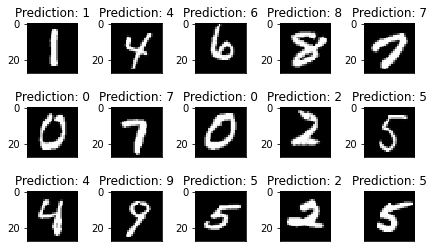

In [220]:
with torch.no_grad():
    output = model(example_data)

fig = plt.figure()
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
plt.yticks([])

print(output.data.max(1,True)[1][0].item())
print(output.data.max(1,True)[1][1].item())
print(output.data.max(1,True)[1][2].item())


In [234]:
from PIL import Image
import cv2


image = cv2.imread("./test_data/test_cell1.jpg")
# roi = cv2.resize(image, (28, 28))
# roi = roi.astype("float") / 255.0
# roi = img_to_array(roi)
# print(roi)




ImportError: /home/kosuke/miniconda3/envs/source_cv4_py36/bin/../lib/libfontconfig.so.1: undefined symbol: FT_Done_MM_Var

## Prep to save the model to be used in C++

In [146]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([32, 1, 5, 5])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([128, 1600])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([10, 128])
fc2.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {140466598930328: {'step': 4690, 'square_avg': tensor([[[[4.3341e-05, 3.8368e-05, 6.2752e-05, 6.4492e-05, 2.4329e-05],
          [6.5469e-05, 7.9749e-05, 1.0045e-04, 6.3590e-05, 3.5428e-05],
          [9.5182e-05, 1.1238e-04, 1.2895e-04, 8.8450e-05, 7.3660e-05],
          [6.8761e-05, 7.0515e-05, 5.3159e-05, 5.4676e-05, 7.5723e-05],
          [5.8572e-05, 5.0048e-05, 4.0376e-05, 3.9879e-05, 4.8963e-05]]],


        [[[3.2676e-05, 6.9174e-05, 6.6171e-05, 3.4924e-05, 2.4718e-05],
          [3.9216e-05, 8.3439e-05, 4.3531e-05, 2.3949e-05, 1.6864e-05],
          [5.2054e-05, 6.1873e-05, 3.3731e-05, 2.9840e-05, 3.0642e-05],
          [6.2428e-05, 5.4302e-05, 3.1562e-05, 2.

In [147]:
example_image, example_label = next(iter(train_loader))
# run the tracing
traced_script_module = torch.jit.trace(model, example_image)
# save the converted model
traced_script_module.save("./models/converted_model.pt")